# Proyecto Final: Animación de un péndulo doble

**Nombre:** Camilo Londoño Vera

**Objetivo:** Construir una animación de un péndulo doble utilizando distintas librerias de python como scipy, numpy, sympy y matplotlib, vistas durante el desarrollo del curso.

In [1]:
#Librerias
import numpy as np
import sympy as smp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

#notacion punto
import sympy.physics.mechanics as mech
from sympy import integrate 
mech.init_vprinting()

## Introducción

El pédulo doble es un sistema con 2 osciladores acoplados que consiste en un péndulo colgando del extremo de otro. Este problema es descrito por medio un sistema de dos ecuaciones diferenciales ordinarias de segundo orden.

Considere un péndulo doble (Figura 1.) con masas $m_1$ y $m_2$, unidos por dos cuerdas de masa despreciable y longitud $l_1$, $l_2$. Sea $\theta_1$ y $\theta_2 $ los ángulos con respecto a la vertical de cada péndulo. Por último, sea $g$ la acelaración gravitacional.

<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/78/Double-Pendulum.svg/200px-Double-Pendulum.svg.png" alt="drawing" width="300" align="center"/>
</p>

**Figura 1** Péndulo doble

Las ecuaciones para este sistema dependeran de $\theta_i$ $(i=1,2)$ y sus respectivas derivadas; no obstante, para poder realizar la animación es necesario tener en cuenta las coordenadas cartesianas del sistema. Estás son: \
$x_1 = l_1 sin(\theta_1) $ \
$y_1 = -l_1  cos(\theta_1) $ \
$ x_2 = l_1 sin(\theta_1) + l_2 sin(\theta_2)$ \
$ y_2 = -l_1  cos(\theta_1) - l_2  cos(\theta_2)$

Una forma para hallar las ecuaciones de movimiento que describen este sistema es por medio de la ecuación diferencial de Euler-Lagrange.

$$\frac{\partial L}{\partial \theta_1} - \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}} = 0$$
$$\frac{\partial L}{\partial \theta_2} - \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}} = 0$$

Recordemos que el Lagrangiano está definido como:
$$L = K - U$$
$K$ es la energía cinética y $U$ es la energía potencial

## Planteamiento del problema con sympy

Ahora, para encontrar las ecuaciones diferenciales que describen el movimiento y sus respectivas soluciones, se utiliza la librería sympy de Python.

In [2]:
#Se definen todos los simbolos a utilizar.
t, g = smp.symbols('t g')
m1, m2 = smp.symbols('m1 m2')
l1, l2 = smp.symbols('l1, l2')

Definimos a $\theta_1$ y $\theta_2$  como dos funciones que dependeran del tiempo.

In [3]:
θ1, θ2 = smp.symbols(r'\theta_1, \theta_2', cls=smp.Function)
θ1 = θ1(t)
θ2 = θ2(t)

Luego, se definen de forma simbólica la primera y la segunda derivada de $\theta_1$ y $\theta_2$. Es decir, definimos a $ \dot \theta_1$, $ \dot \theta_2$, $ \ddot \theta_1$, $ \ddot \theta_2$

In [4]:
θ1_d = smp.diff(θ1, t)
θ2_d = smp.diff(θ2, t)
θ1_dd = smp.diff(θ1_d, t)
θ2_dd = smp.diff(θ2_d, t)

Definimos las coordenadas cartesianas en sympy.

In [5]:
x1 = l1*smp.sin(θ1)
y1 = -l1*smp.cos(θ1)
x2 = l1*smp.sin(θ1)+l2*smp.sin(θ2)
y2 = -l1*smp.cos(θ1)-l2*smp.cos(θ2)

La energía potencial está dada por: 

$U = m_1 g y_1 + m_2 g y_2$ \
$U = -(m_1 + m_2 ) g l_1 cos(\theta_1)  - m_2  g l_2 cos(\theta_2)$

Por otro lado, la energía cinética es:

$ K = \frac{1}{2} m_1 v_1^2 +  \frac{1}{2} m_2 v_2^2$

In [6]:
# Energía cinética
K1 = 1/2 * m1 * (smp.diff(x1, t)**2 + smp.diff(y1, t)**2)
K2 = 1/2 * m2 * (smp.diff(x2, t)**2 + smp.diff(y2, t)**2)
K = K1+K2
# Energía Potential
U1 = m1*g*y1
U2 = m2*g*y2
U = U1 + U2
# Lagrangiano
L = K-U

Así se obtiene que el Lagrangiano es:

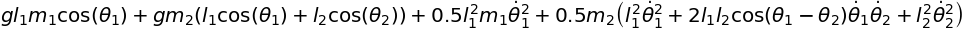

In [7]:
smp.simplify(L)

Como se mencionó antes, para obtener las ecuaciones que describen el movimiento se utiliza la ecuación de Euler-Lagrange para cada $\theta_i$

$$\frac{\partial L}{\partial \theta_1} - \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}} = 0$$
$$\frac{\partial L}{\partial \theta_2} - \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}} = 0$$

Dichas ecuaciones se resuelven por medio de sympy.

In [8]:
#Ecuaciones Euler-Lagrange
LE1 = smp.diff(L, θ1) - smp.diff(smp.diff(L, θ1_d), t).simplify()
LE2 = smp.diff(L, θ2) - smp.diff(smp.diff(L, θ2_d), t).simplify()

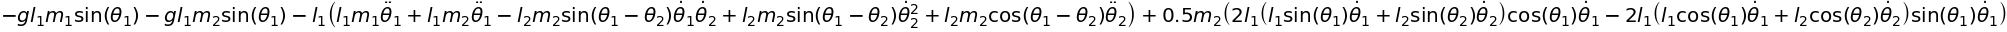

In [9]:
LE1

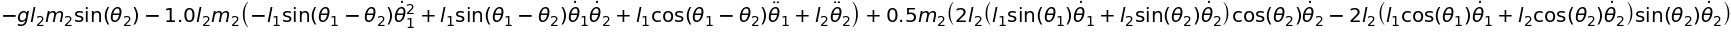

In [10]:
LE2

Para resolver las ecuaciones de Euler-Lagrange solo basta utilizar smp.solve con LE1 y LE2.

In [11]:
sols = smp.solve([LE1, LE2], (θ1_dd, θ2_dd),
                simplify=True, rational=False)

Así se tiene que el sistema de ecuaciones diferenciales ordianarias que describe el movimiento de un péndulo doble es:

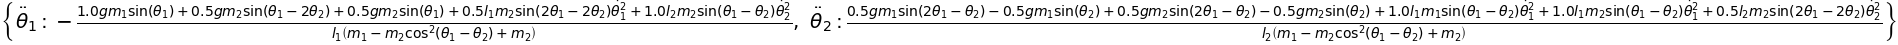

In [12]:
sols

## Solución del sistema de ecuaciones con ODEINT


Se tiene un sistema de ecuaciones diferenciales de segundo orden. Sin embargo, para poder resolverlo utilizando la librería scipy de Python se debe transformar a un sistema de primer orden, esto se logra haciendo un simple cambio de variable.

$\dot \theta_1 = z_1$\
$\dot \theta_2 = z_2$

De manera que el sistema a resolver quedaría de la forma: \
$\dot z_1 = \frac{ - 1.0𝑔𝑚_1sin(𝜃_1)+0.5𝑔𝑚_2sin(𝜃_1−2𝜃_2)+0.5𝑔𝑚_2sin(𝜃_1)+0.5𝑙_1𝑚_2sin(2𝜃_1−2𝜃_2)𝜃˙_1^2+1.0_2𝑚2sin(𝜃_1−𝜃_2)𝜃˙_2^2}{l_1 (𝑚_1−𝑚_2cos(𝜃_1−𝜃_2)^2+ m_2)} $ \
$\dot \theta_1 = z_1$ \
$\dot z_2 = \frac{(−(𝑚_1+𝑚_2)(𝑔sin(𝜃_2)−𝑙_1sin(𝜃_1−𝜃_2)𝜃˙_1^2)+(𝑔𝑚_1sin(𝜃_1)+𝑔𝑚_2sin(𝜃_1)+𝑙_2𝑚_2sin(𝜃_1−𝜃_2)𝜃˙_2^2)cos(𝜃_1−𝜃_2))}{𝑙_2(𝑚_1−𝑚_2cos(𝜃_1−𝜃_2)^2+𝑚_2}$ \
$\dot \theta_2 = z_2$ \


Para resolver el sistema de ecuaciones utilizando scipy también es necesario pasar las expresiones simbólicas de sympy a funciones numéricas, esto se hace por medio de sympy.lambdify.

In [13]:
dz1dt_f = smp.lambdify((t,g,m1,m2,l1,l2,θ1,θ2,θ1_d,θ2_d), sols[θ1_dd])
dz2dt_f = smp.lambdify((t,g,m1,m2,l1,l2,θ1,θ2,θ1_d,θ2_d), sols[θ2_dd]) 
dθ1dt_f = smp.lambdify(θ1_d, θ1_d)
dθ2dt_f = smp.lambdify(θ2_d, θ2_d)

Al usar scipy.integrate.odeint es necesario crear una función derivs() que contenga el sistema de EDOs

In [14]:
def derivs(S, t, g, m1, m2, l1, l2):
    θ1, z1, θ2, z2 = S
    return [
        dθ1dt_f(z1),
        dz1dt_f(t, g, m1, m2, l1, l2, θ1, θ2, z1, z2),
        dθ2dt_f(z2),
        dz2dt_f(t, g, m1, m2, l1, l2, θ1, θ2, z1, z2),
    ]

Resolvamos el sistema

In [53]:
t = np.linspace(0, 50, 800)
g = 9.8
m1=2
m2=1
l1 = 1
l2 = 2
ans = odeint(derivs, y0=[1.5, 0, 0.7, 0], t=t, args=(g,m1,m2,l1,l2))

(Se invita a cambiar los anteriores valores al gusto)

In [54]:
#Solución del sistema de EDOs
ans.T

array([[ 1.5       ,  1.48055641,  1.4218287 , ...,  0.23646832,
         0.09962732, -0.03632519],
       [ 0.        , -0.62248049, -1.25757142, ..., -2.18476329,
        -2.18283706, -2.16157456],
       [ 0.7       ,  0.70065975,  0.7035738 , ..., -1.78835862,
        -1.77099599, -1.72582221],
       [ 0.        ,  0.02360063,  0.07680576, ...,  0.05935627,
         0.49817027,  0.94621185]])

Ahora veamos los datos de $\theta_1$ y $\theta_2$ en una gráfica

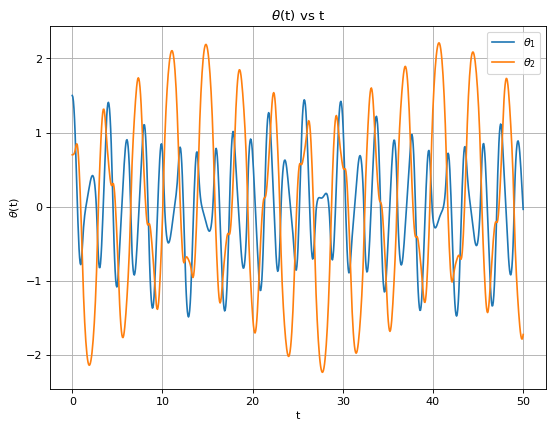

In [55]:
θ1 = ans.T[0]
θ2 = ans.T[2]


#Gráfica
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(t, θ1, label = "$θ_1$")
plt.plot(t, θ2, label = "$ θ_2$")
plt.legend()
plt.xlabel("t")
plt.ylabel("$ θ $(t)")
plt.title("$ θ $(t) vs t")
plt.grid();

## Animación



In [56]:
def coordcart(t, θ1, θ2, l1, l2):
    """ De coordenadas polares a coordenadas cartesianas"""
    return (l1*np.sin( θ1),
            -l1*np.cos( θ1),
            l1*np.sin( θ1) + l2*np.sin( θ2),
            -l1*np.cos( θ1) - l2*np.cos( θ2))

x1, y1, x2, y2 = coordcart(t, θ1, θ2, l1, l2)

La animación se crea automaticamente en un archivo independiente.

In [57]:
from matplotlib.pyplot import cm
def animate(i):
  return ln1.set_data([0, x1[i], x2[i]], [0, y1[i], y2[i]]), ln2.set_data([x2[:i]],[y2[:i]])
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.get_xaxis().set_ticks([])    
ax.get_yaxis().set_ticks([])  

ln1, = plt.plot([], [], 'bo-', lw=3, markersize=8)
ln2, = plt.plot([], [], 'r--', lw=2, markersize=8)

ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
ani = animation.FuncAnimation(fig, animate, frames=300, interval=50)
ani.save('pen.gif',writer='pillow',fps=25)
plt.close(fig)
#Para reproducir en colab:
from IPython.display import HTML
HTML(ani.to_html5_video())